In [113]:
import yfinance as yf

data = yf.download(tickers = "NEM", start="2017-12-01", end="2023-06-16", interval='1d')

[*********************100%***********************]  1 of 1 completed


In [114]:
data = data.reset_index('Date', inplace=False)

In [115]:
df = data

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional

In [117]:
df1=df.reset_index()['Close']

In [118]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [119]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [120]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [121]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [122]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [123]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add a bidirectional LSTM layer
model.add(Bidirectional(LSTM(100, activation='relu')))

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [124]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 7s 185ms/step - loss: 0.0569 - val_loss: 0.0483
Epoch 2/100
14/14 [==============================] - 2s 153ms/step - loss: 0.0094 - val_loss: 0.0399
Epoch 3/100
14/14 [==============================] - 2s 154ms/step - loss: 0.0054 - val_loss: 0.0233
Epoch 4/100
14/14 [==============================] - 3s 251ms/step - loss: 0.0038 - val_loss: 0.0157
Epoch 5/100
14/14 [==============================] - 2s 150ms/step - loss: 0.0029 - val_loss: 0.0084
Epoch 6/100
14/14 [==============================] - 2s 139ms/step - loss: 0.0024 - val_loss: 0.0080
Epoch 7/100
14/14 [==============================] - 2s 135ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 8/100
14/14 [==============================] - 2s 142ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 9/100
14/14 [==============================] - 2s 144ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 10/100
14/14 [==============================] - 4s 264ms/step - loss: 0.0018 - val_lo

In [125]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 15ms/step


In [126]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [127]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [128]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1.379034884193329
Testing RMSE: 2.3490020965084355


In [129]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 1.1775573339217749
Testing MAE: 1.863068532135527


In [130]:
from sklearn.metrics import mean_absolute_percentage_error

In [131]:
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 1.379034884193329
Testing MAPE: 2.3490020965084355


In [132]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[40:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.24800491]
101
1 day input [0.45664638 0.43944826 0.4249373  0.4145468  0.41795057 0.4405231
 0.40899321 0.36277318 0.32246504 0.34252959 0.33590109 0.32210681
 0.32927266 0.33500537 0.31189535 0.29917591 0.29111427 0.28341094
 0.27893225 0.26209244 0.26262986 0.2497313  0.24614834 0.25098532
 0.2597635  0.25689715 0.27051238 0.26191332 0.23109997 0.22500896
 0.2174848  0.22500896 0.27803653 0.27355785 0.29577214 0.28986025
 0.33267643 0.32640631 0.30455032 0.30526692 0.32586889 0.33948405
 0.33339304 0.34145468 0.33572197 0.34467934 0.34790399 0.35596563
 0.38964527 0.40254389 0.40218559 0.38498747 0.36402721 0.36026513
 0.38373345 0.35686136 0.33805091 0.34503764 0.33428876 0.32748121
 0.32282335 0.32998927 0.33321392 0.31440347 0.33446795 0.31888215
 0.31046221 0.33070587 0.32049448 0.35489072 0.34252959 0.33482625
 0.3323182  0.32622719 0.29165176 0.2927266  0.31332856 0.27803653
 0.2714081  0.24489431 0.25188105 0.24596922 0.23092085 0.21873883
 0.19777856 0.19849517 0.19347907 

In [133]:
# 12. Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(ytest, y_pred)
valid_mae = mean_absolute_error(yval, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(ytest, y_pred)
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 2.3490020965084355
Validation RMSE: 1.379034884193329
Testing MAE: 1.863068532135527
Validation MAE: 1.1775573339217749
Testing MAPE: 0.03124896907298818
Validation MAPE: 0.026839738908102005


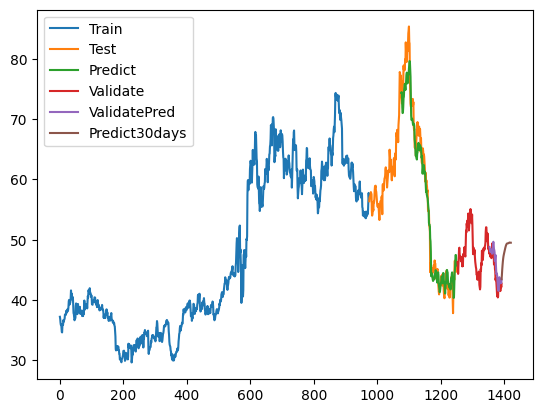

In [134]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [135]:
scaler.inverse_transform(lst_output)

array([[43.44363409],
       [44.16104009],
       [45.06006087],
       [45.76705627],
       [46.38672447],
       [46.87728334],
       [47.24683944],
       [47.52588925],
       [47.77407993],
       [48.01150401],
       [48.24989295],
       [48.48145962],
       [48.70619402],
       [48.90241989],
       [49.07451575],
       [49.20068888],
       [49.29726219],
       [49.35519919],
       [49.38096117],
       [49.39246306],
       [49.39724082],
       [49.4047252 ],
       [49.42735967],
       [49.46620226],
       [49.5039835 ],
       [49.53049575],
       [49.52284834],
       [49.4972261 ],
       [49.49871832],
       [49.49548435]])